# Activation functions and the vanishing gradient problem

In this tutorial we will take a closer look at (popular)
activation functions and their effect on optimization properties in neural networks. 

Picking a good activation function can help to face what is called **vanishing gradient problem**.

During the training process of the neural network, the goal is to minimize a loss function by adjusting the weights of the network. The backpropogation algorithm calculates these gradients by propogating the error from the output layer to the input layer. The consequences of vanishing gradient problem is that the gradients of the loss function to the weights of the early layers become vanishing small. As a result, early layers receive little or no update weight information during backpropagation, leading to slow convergency or staying in a local minimal.

Activation functions, such as sigmoid and hyperbolic tangent, are responsible for introducing non-linearity into the DNN model. However, these functions suffer from the saturation problem, where the gradients become close to zero for large or small inputs, contributing to the vanishing gradient problem.

In [0]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/tmp/ipykernel_13054/4171804764.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [1]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cuda:0


## Common activation functions

In [2]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}


class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)


class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)

## Visualizing activation functions

In [3]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

We can visualize the activation functions against their gradients:

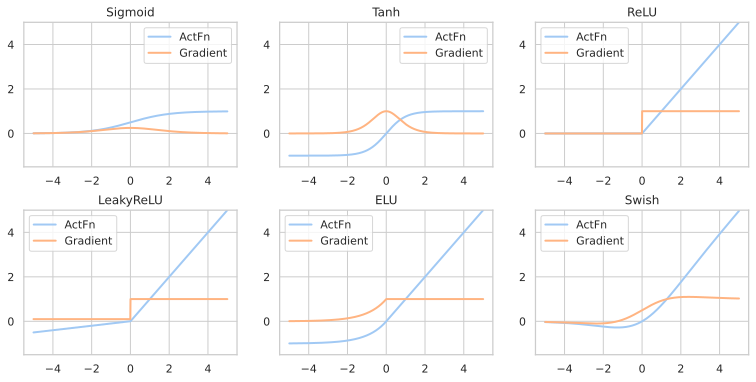

In [4]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = (
        x.clone().requires_grad_()
    )  # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()  # Summing results in an equal gradient flow to each element in x
    return x.grad  # Accessing the gradients of x by "x.grad"


def vis_act_fn(act_fn, x, ax):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(
    -5, 5, 1000
)  # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns) / 3.0)
fig, ax = plt.subplots(rows, 3, figsize=(13, rows * 3))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, x, ax[divmod(i, 3)])
fig.subplots_adjust(hspace=0.3)
plt.show()

## Analysing the effect of activation functions

In [5]:
class BaseNetwork(nn.Module):

    def __init__(
        self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]
    ):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]),
                act_fn,
            ]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(
            *layers
        )  # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {
            "act_fn": act_fn.config,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Reshape images to a flat vector
        out = self.layers(x)
        return out

In [6]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(
    root=DATASET_PATH, train=True, transform=transform, download=True
)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(
    root=DATASET_PATH, train=False, transform=transform, download=True
)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False
)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

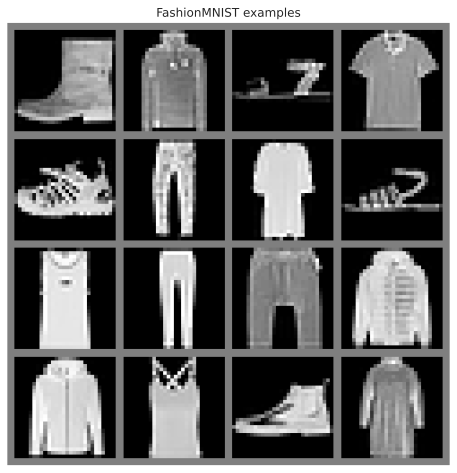

In [7]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(
    torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [8]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if "weight" in name
    }
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(
        f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}",
        fontsize=14,
        y=1.05,
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

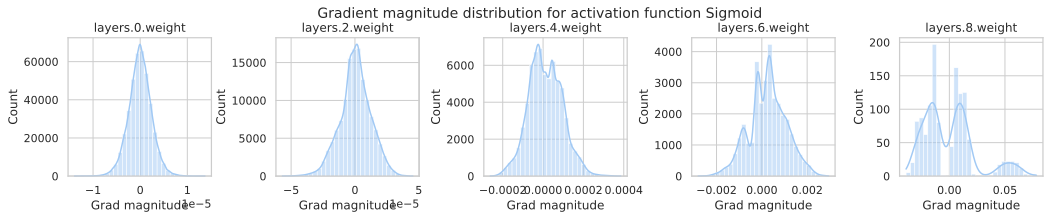

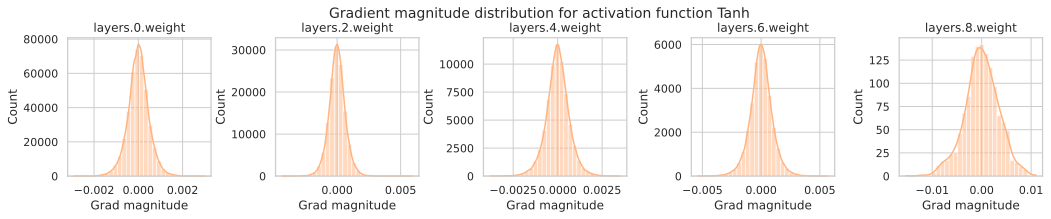

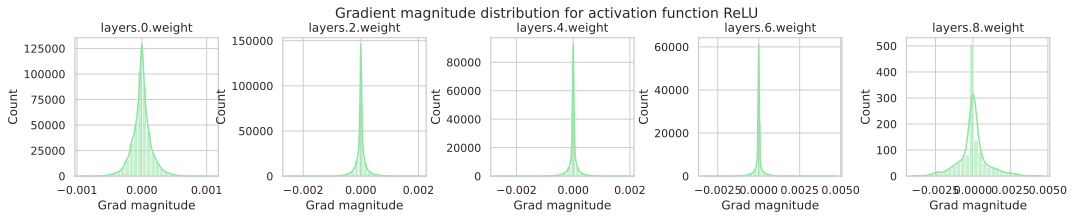

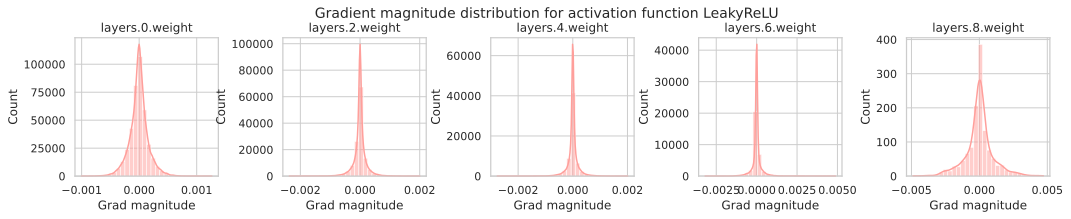

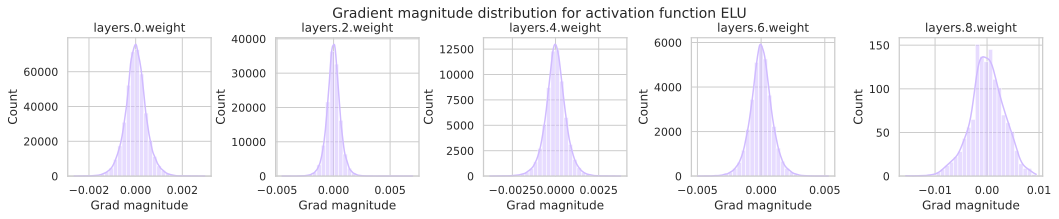

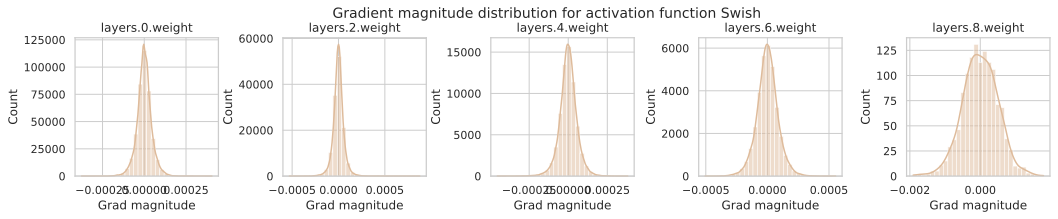

In [9]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings

warnings.filterwarnings("ignore")
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(
        42
    )  # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient, and finding a suitable learning rate across all layers is not possible in this setup. All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons.